In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import random
import elasticdeform
import h5py
import os

np.random.seed(10)
print("hi")

hi


<KeysViewHDF5 ['acquisition', 'filename', 'kspace', 'sensmaps', 'target']>
(640, 372)


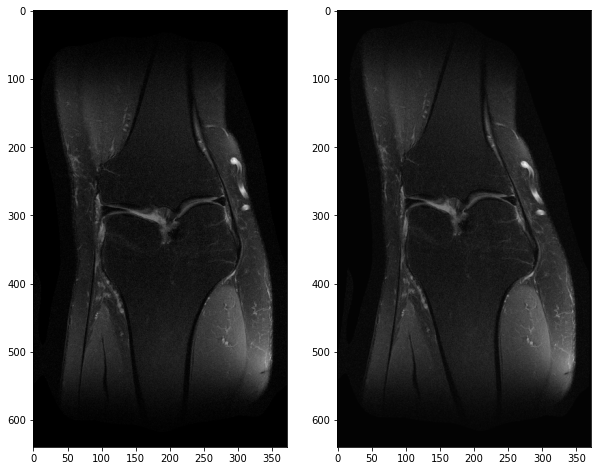

In [15]:
#Testing some elastic deform
def normalize(img):
    return img/np.percentile(img, 95)

hf = h5py.File('/mikQNAP/NYU_knee_data/knee_train_h5/data/train/184_10.h5', 'r')
print(hf.keys())
im = hf.get('target')
print(im.shape)

np_im = normalize(np.abs(np.array(im)))

# This method will show image in any image viewer 
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(np_im, cmap='gray') 

deform = elasticdeform.deform_random_grid(np_im, 20, axis=(0, 1))  #15-30
plt.subplot(1,2,2)
plt.imshow(normalize(deform), cmap='gray')

In [16]:
# Set Up Registration Dataset
class RegistrationDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        self.data_paths = os.listdir(data_dir)  
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, index):
        #Select Image 1 and apply Normalization Transforms (fixed output)        
        hf = h5py.File(os.path.join(self.data_dir, self.data_paths[index]), 'r')
        im = normalize(np.abs(np.array(hf.get('target'))))
        im = np.expand_dims(im, axis=2)
        if self.transform:
            im = self.transform(im)
        
        imT = im
        #Apply Smooth Transform to Image 2 (moving input)
        if self.target_transform:
            imT = self.target_transform(imT)

        return imT, im  
    def __len__(self):
        return len(self.data_paths)

In [17]:
#Set Up Elastic Deform Transform
class ElasticDeform(object):
    """Performs elastic deformation on an image.
    Args:
        sig_min = minimum of range of standard deviation of the normal distribution
        sig_max = maximum of range of standard deviation of the normal distribution
    """

    def __init__(self, sig_min, sig_max):
        self.sig_min = sig_min  #15
        self.sig_max = sig_max  #30

    def __call__(self, img):
        """
        Args:
            img (np array): Image to be deformed elastically
        Returns:
            np array: Elastic Deformed image.
        """
        sig = random.randrange(self.sig_min, self.sig_max+1)
        deform = elasticdeform.deform_random_grid(img, sig, axis=(0,1))
        i = np.argwhere(deform<0)
        mask = np.zeros(deform.shape)
        mask[i] = 1
        return mask

    def __repr__(self):
        return self.__class__.__name__


In [18]:
#Loading Data and Setting Up Transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop((256, 256))])

target_transform = transforms.Compose(
    [transforms.RandomPerspective(distortion_scale=0.6, p=1.0)])

batch_size = 4

trainset = RegistrationDataset("/mikQNAP/NYU_knee_data/knee_train_h5/data/train", transform, target_transform)

testset = RegistrationDataset("/mikQNAP/NYU_knee_data/knee_train_h5/data/test", transform, target_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


/home/anacis/venv/lib/python3.6/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/home/anacis/venv/lib/python3.6/site-packages/torchvision/transforms/functiona

torch.Size([4, 1, 256, 256])


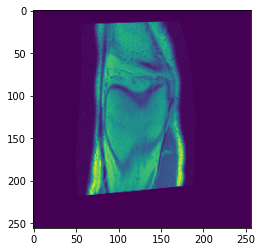

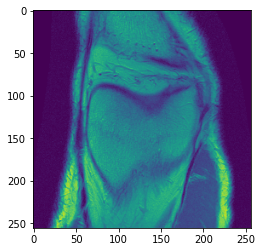

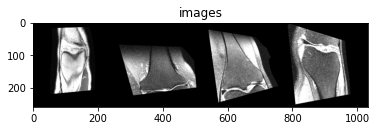

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


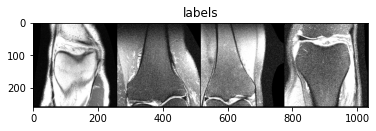

In [19]:
#Visualize Data

# functions to show an image
def imshow(img, title):
    plt.figure()
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0)
    plt.title(title)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
plt.figure()
plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.figure()
plt.imshow(np.transpose(labels[0], (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images), "images")
imshow(torchvision.utils.make_grid(labels), "labels")

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(1,1),  padding=(1,1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out) #Todo: do we want a relu?
        return out

In [8]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, conv1_out_chan, out_channels, stride=1):
        super(DownsampleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels = conv1_out_chan, kernel_size=(1,1), stride=2, padding=(1,1))
        self.bn1 = nn.BatchNorm2d(conv1_out_chan)
        
        self.pool = nn.MaxPool2d(2) #check with alfredo about kernel size
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1,1),  padding=(1,1))
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.pool(x)
        print(out1.shape)
        print(out2.shape)
        out = torch.cat((out1, out2), dim=1)
        print(out.shape)
        print()
        
        out = F.relu(self.bn2(self.conv2(out)))
        
        return out

In [13]:
class RegistrationNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Pre Concat (ran twice in parallelish)
        #In channels should be 1 because magnitude
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (3,3), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(32)
        self.resnet1 = ResidualBlock(32, 32)
        self.downsample1 = DownsampleBlock(32, 32, 64)
        self.resnet21 = ResidualBlock(64, 64)
        self.resnet22 = ResidualBlock(64, 64)
        self.downsample2 = DownsampleBlock(64, 64, 128)
        self.resnet3 = ResidualBlock(128, 128)
        
    
        #Post Concat
        self.conv2 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (3,3),  padding=(1,1))
        self.bn2 = nn.BatchNorm2d(128)
        self.resnet41 = ResidualBlock(128, 128)
        self.resnet42 = ResidualBlock(128, 128)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3),  padding=(1,1))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size = (3,3),  padding=(1,1))
        self.bn4 = nn.BatchNorm2d(2)  #should contain deformation field

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = self.downsample1(self.resnet1(x1))
        x1 = self.downsample2(self.resnet22(self.resnet21(x1)))
        x1 = self.resnet3(x1)
        
#         x2 = F.relu(self.bn1(self.conv1(x[1])))
#         x2 = self.downsample(self.resnet1(x2))
#         x2 = self.downsample2(self.resnet22(self.resnet21(x2)))
#         x2 = self.resnet3(x2) #Will this make the weights be shared?
        
#         x = torch.cat((x1, x2))
        
        x = F.relu(self.bn2(self.conv2(x1)))
        x = self.resnet42(self.resnet41(x))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        return x


net = RegistrationNet()

TypeError: __init__() got an unexpected keyword argument 'pad'

In [10]:
#Set up Tensorboard
log_dir = "checkpoints/heartvista_simple/logs"
summary_train = SummaryWriter(os.path.join(log_dir, "train"))
summary_eval = SummaryWriter(os.path.join(log_dir, "eval"))

In [11]:
#Set up loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
#Train Model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        deform_fields = net(inputs)
        outputs = F.grid_sample(inputs, deform_fields) #apply deformation field to input
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            
            
            summary_train.add_scalar("Loss", loss, epoch)
            summary_train.add_images("Input", noisy[:max_to_plot], epoch)
            summary_train.add_images("Output", output[:max_to_plot], epoch)
            summary_train.add_images("Ground Truth", ground_truth[:max_to_plot], epoch)
            running_loss = 0.0
print('Finished Training')

/home/anacis/venv/lib/python3.6/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/home/anacis/venv/lib/python3.6/site-packages/torchvision/transforms/functiona

torch.Size([4, 32, 127, 127])
torch.Size([4, 32, 127, 127])
torch.Size([4, 64, 127, 127])

torch.Size([4, 64, 64, 64])
torch.Size([4, 64, 63, 63])


RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 1. Got 64 and 63 in dimension 2 (The offending index is 1)

In [ ]:
#Save Model
PATH = '/heartvista_simple_1'
torch.save(net.state_dict(), PATH)

In [ ]:
# Visualize Test Data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Run Network on Sample of Test Data
net = RegistrationNet()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)


In [ ]:
#Run Network on All Test Data
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))